https://www.kaggle.com/vbmokin/nlp-eda-bag-of-words-tf-idf-glove-bert#Acknowledgements

In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
import pandas as pd
import numpy as np
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from nltk.corpus import stopwords
from nltk.util import ngrams

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix

from collections import defaultdict
from collections import Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))

import re
from nltk.tokenize import word_tokenize
import gensim
import string

from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from keras.initializers import Constant
from keras.optimizers import Adam

In [0]:
tweet= pd.read_csv('/content/drive/My Drive/WSU/Semester 2/IE 7860/Final Project/drugsComTrain_raw.csv')
test=pd.read_csv('/content/drive/My Drive/WSU/Semester 2/IE 7860/Final Project/drugsComTest_raw.csv')

In [0]:
tweet = tweet.loc[(tweet['rating'] <= 3) | (tweet['rating'] == 10)]
tweet['target']=tweet['rating'].apply(lambda x: 1 if x>=8 else 0)

test = test.loc[(test['rating'] <= 3) | (test['rating'] == 10)]
test['target']=test['rating'].apply(lambda x: 1 if x>=8 else 0)

In [0]:
tweet['text'] = tweet['review']
tweet['keyword'] = tweet['rating']
tweet['location'] = tweet['condition']
tweet['id'] = tweet['uniqueID']
tweet.drop(['uniqueID','drugName', 'condition', 'review', 'rating', 'usefulCount', 'date'],axis=1,inplace=True)

In [0]:
test['text'] = test['review']
test['keyword'] = test['rating']
test['location'] = test['condition']
test['id'] = test['uniqueID']
test.drop(['uniqueID','drugName', 'condition', 'review', 'rating', 'usefulCount', 'date'],axis=1,inplace=True)

In [0]:
# extracting the number of examples of each class
Real_len = tweet[tweet['target'] == 1].shape[0]
Not_len = tweet[tweet['target'] == 0].shape[0]

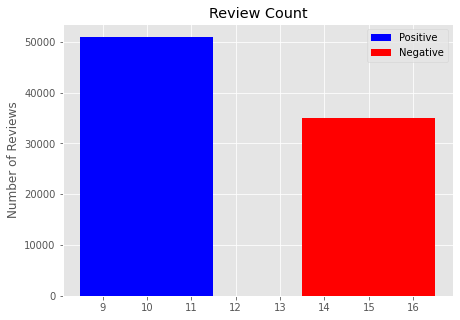

In [0]:
# bar plot of the 3 classes
plt.rcParams['figure.figsize'] = (7, 5)
plt.bar(10,Real_len,3, label="Positive", color='blue')
plt.bar(15,Not_len,3, label="Negative", color='red')
plt.legend()
plt.ylabel('Number of Reviews')
plt.title('Review Count')
plt.show()

In [0]:
def length(text):    
    '''a function which returns the length of text'''
    return len(text)

In [0]:
tweet['length'] = tweet['text'].apply(length)

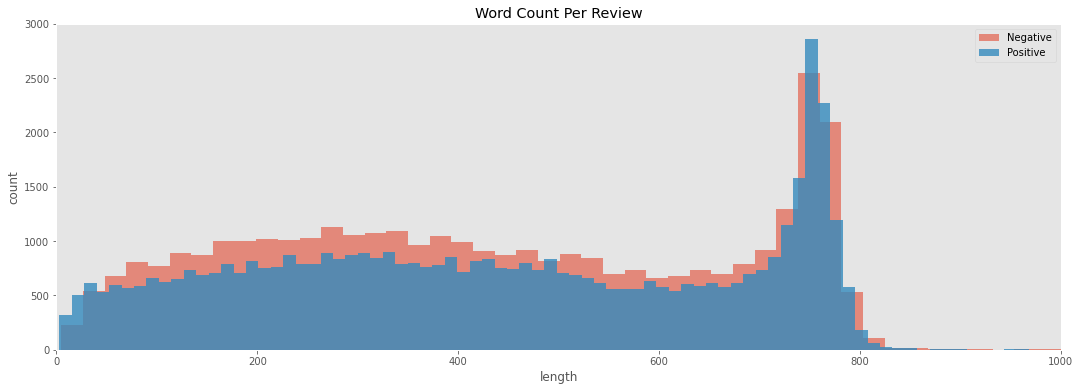

In [0]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 500
plt.hist(tweet[tweet['target'] == 0]['length'], alpha = 0.6, bins=bins, label='Negative')
plt.hist(tweet[tweet['target'] == 1]['length'], alpha = 0.8, bins=bins, label='Positive')
plt.xlabel('length')
plt.ylabel('count')
plt.title('Word Count Per Review')
plt.legend(loc='upper right')
plt.xlim(0,1000)
plt.grid()
plt.show()

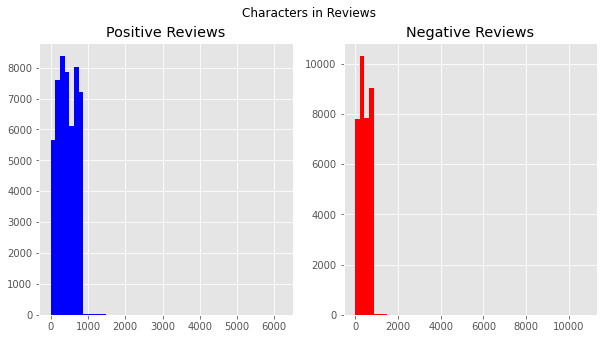

In [0]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.len()
ax1.hist(tweet_len, bins=50, color='blue')
ax1.set_title('Positive Reviews')
tweet_len=tweet[tweet['target']==0]['text'].str.len()
ax2.hist(tweet_len, bins=50, color='red')
ax2.set_title('Negative Reviews')
fig.suptitle('Characters in Reviews')
plt.show()

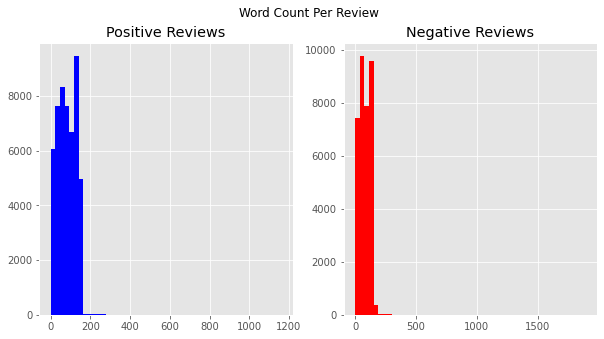

In [0]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len, bins=50,color='blue')
ax1.set_title('Positive Reviews')
tweet_len=tweet[tweet['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len, bins=50,color='red')
ax2.set_title('Negative Reviews')
fig.suptitle('Word Count Per Review')
plt.show()

Text(0.5, 0.98, 'Average Word Length Per Review')

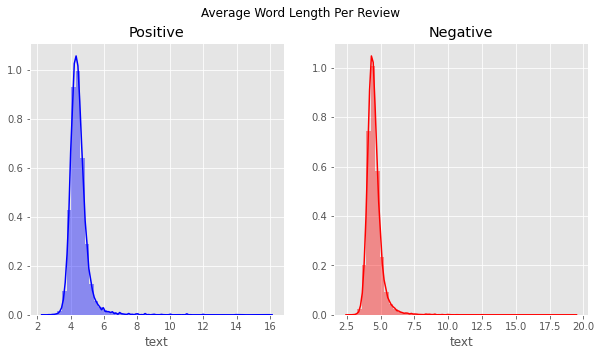

In [0]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=tweet[tweet['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='blue')
ax1.set_title('Positive')
word=tweet[tweet['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title('Negative')
fig.suptitle('Average Word Length Per Review')

In [0]:
def create_corpus(target):
    corpus=[]
    
    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [0]:
def create_corpus_df(tweet, target):
    corpus=[]
    
    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [0]:
corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]

In [0]:
# displaying the stopwords
np.array(stop)

array({'above', 'o', "haven't", 'through', 'having', 'needn', 'own', "don't", "shouldn't", 'most', 'under', 'or', 'about', 'will', 'wouldn', 'only', 'each', 'am', 'yours', 'herself', 'myself', 'weren', 'those', 'below', 'during', 'nor', 'all', 'out', "wasn't", 'here', 'has', 'why', 'doesn', "mustn't", 'd', 'when', 'you', 'a', 'with', 'not', "shan't", 'won', 'ourselves', 'more', 'up', 'until', 'this', 'does', "that'll", 'y', "you'd", "hasn't", 'her', 'and', 'should', 'them', 'were', 'which', "didn't", "she's", "should've", 'their', 'himself', 'what', 'wasn', "you're", 'couldn', "weren't", 'hadn', 'same', 'me', 'an', 'on', 'we', "you've", 'in', 'him', "won't", 'had', 'now', 'mustn', 'm', 'our', 'themselves', 'can', 'yourself', 'other', 'doing', 'yourselves', 're', 'll', 'into', 'his', 'few', 'was', "couldn't", 'over', 'been', 'have', 'they', "needn't", 'as', 'who', 't', 'shouldn', 'ma', 'theirs', 'at', "mightn't", 'again', 'your', 'aren', 'be', 'there', 'some', "hadn't", 'so', 'down', 'i

Text(0.5, 1.0, 'Most Common Stopwords')

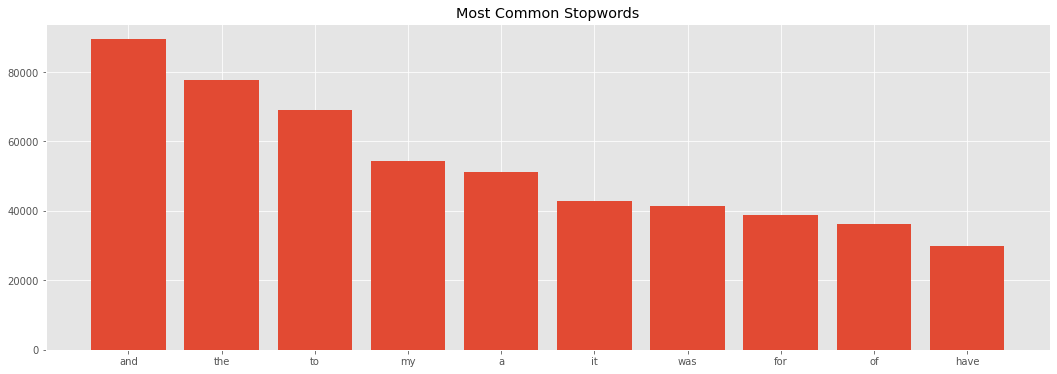

In [0]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
x,y=zip(*top)
plt.bar(x,y)
plt.title('Most Common Stopwords')

<BarContainer object of 10 artists>

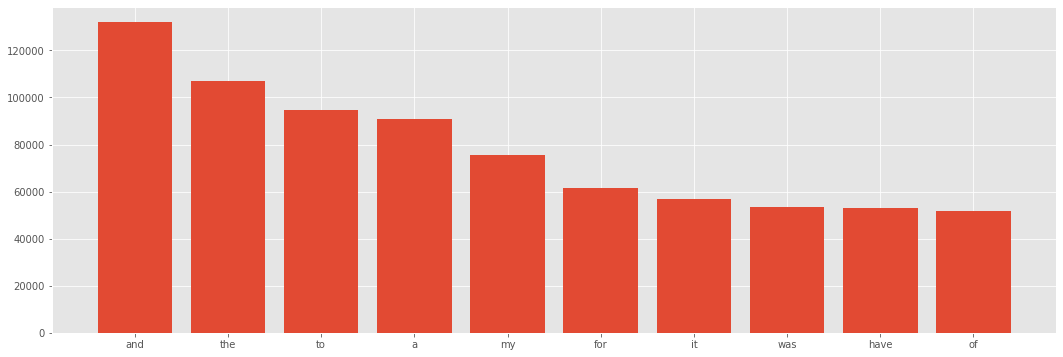

In [0]:
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    

plt.rcParams['figure.figsize'] = (18.0, 6.0)
x,y=zip(*top)
plt.bar(x,y)

Text(0.5, 1.0, 'Special Characters')

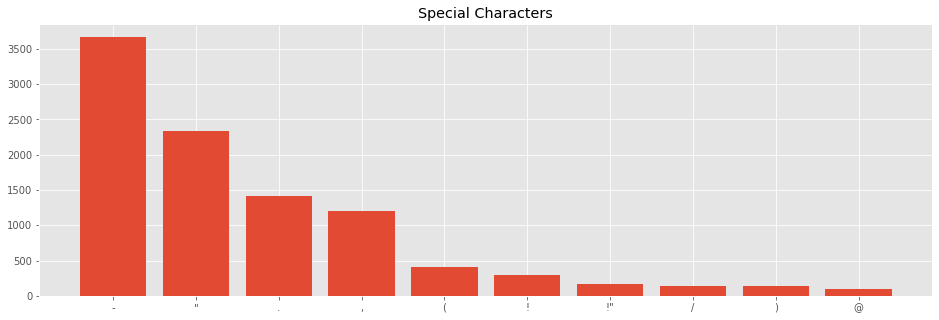

In [0]:
plt.figure(figsize=(16,5))
corpus=create_corpus(1)

dic2=defaultdict(int)
special = string.punctuation
for i in (corpus):
    if i in special:
        dic2[i]+=1
top=sorted(dic2.items(), key=lambda x:x[1],reverse=True)[:10]         
x,y=zip(*top)
plt.bar(x,y)
plt.title('Special Characters')

<BarContainer object of 22 artists>

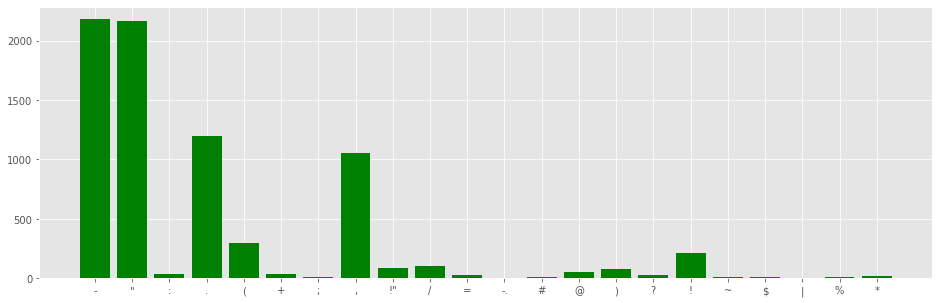

In [0]:
plt.figure(figsize=(16,5))
corpus=create_corpus(0)
dic=defaultdict(int)
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color='green')

In [0]:
plt.figure(figsize=(16,5))
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

<Figure size 1152x360 with 0 Axes>

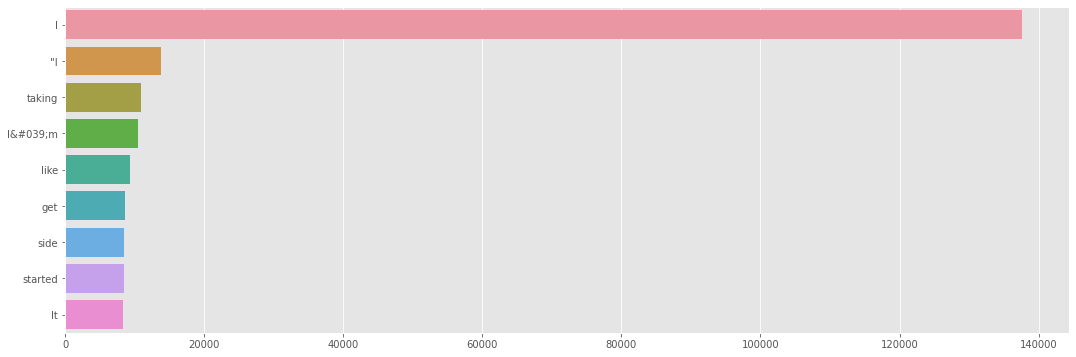

In [0]:
sns.barplot(x=y,y=x)

In [0]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

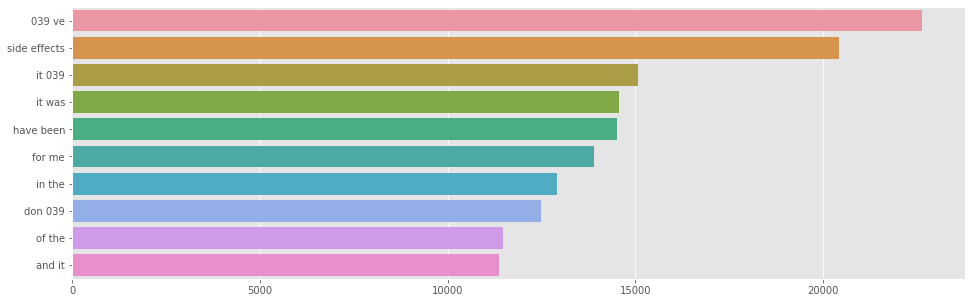

In [0]:
plt.figure(figsize=(16,5))
top_tweet_bigrams=get_top_tweet_bigrams(tweet['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

In [0]:
df=pd.concat([tweet,test])
df.shape

(114906, 6)

In [0]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)


df['text']=df['text'].apply(lambda x : remove_URL(x))



In [0]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

df['text']=df['text'].apply(lambda x : remove_html(x))

In [0]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

df['text']=df['text'].apply(lambda x : remove_punct(x))

In [0]:
corpus_new1=create_corpus_df(df,1)
len(corpus_new1)

5571388

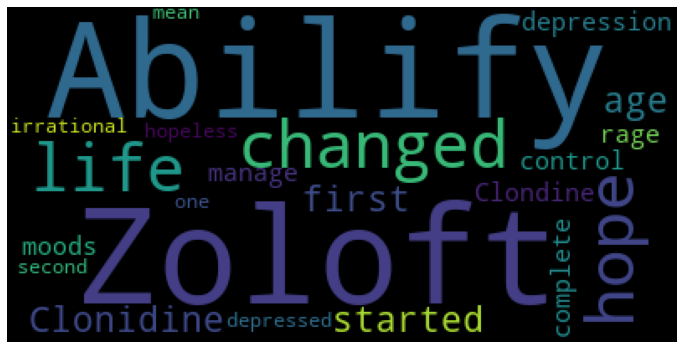

In [0]:
# Generating the wordcloud with the values under the category dataframe
plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='black',
                          max_font_size = 80
                         ).generate(" ".join(corpus_new1[:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

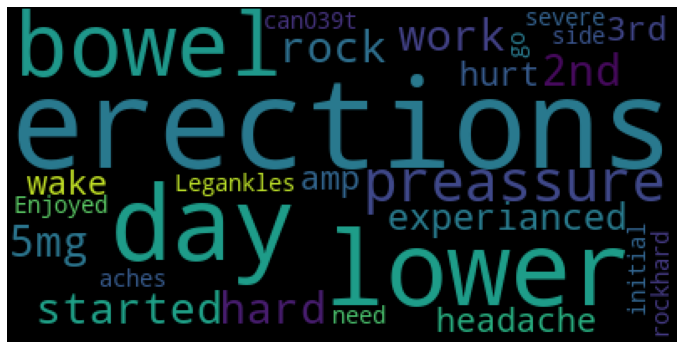

In [0]:
corpus_new0=create_corpus_df(df,0)
len(corpus_new0)

corpus_new0[:10]


# Generating the wordcloud with the values under the category dataframe
plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='black',
                          max_font_size = 80
                         ).generate(" ".join(corpus_new0[:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [0]:
def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = df["text"].tolist()
list_labels = df["target"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=10)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

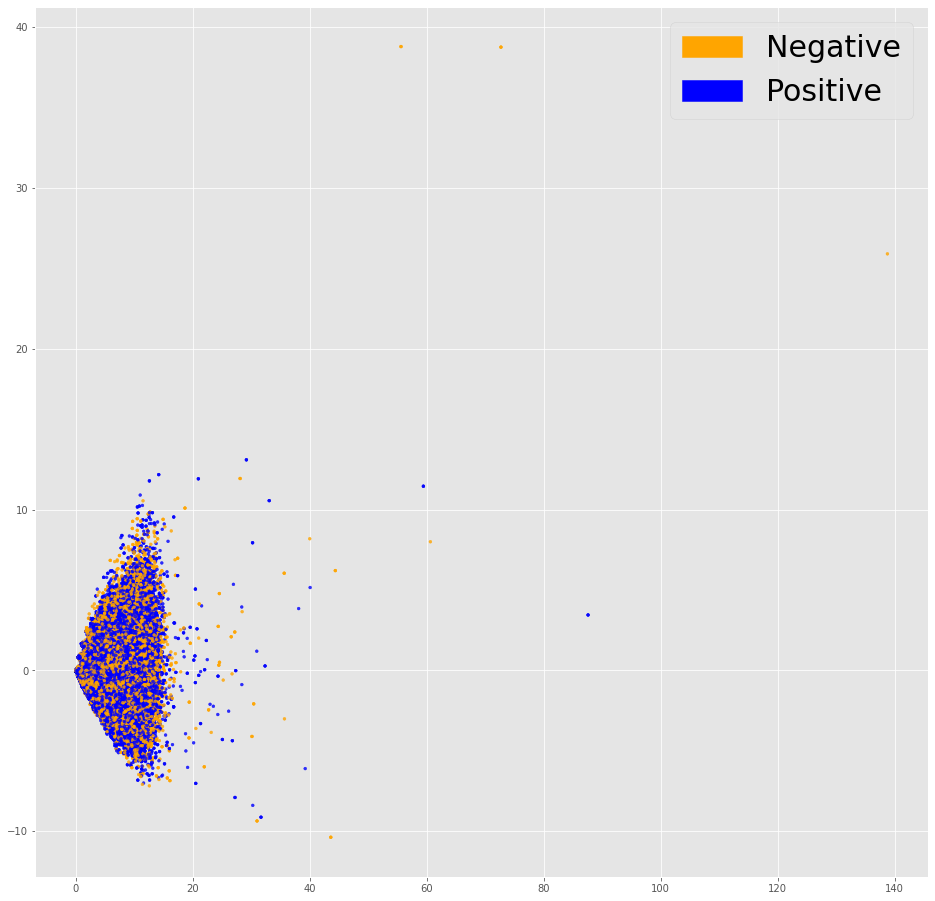

In [0]:
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = mpatches.Patch(color='orange', label='Negative')
            blue_patch = mpatches.Patch(color='blue', label='Positive')
            plt.legend(handles=[orange_patch, blue_patch], prop={'size': 30})

fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.show()

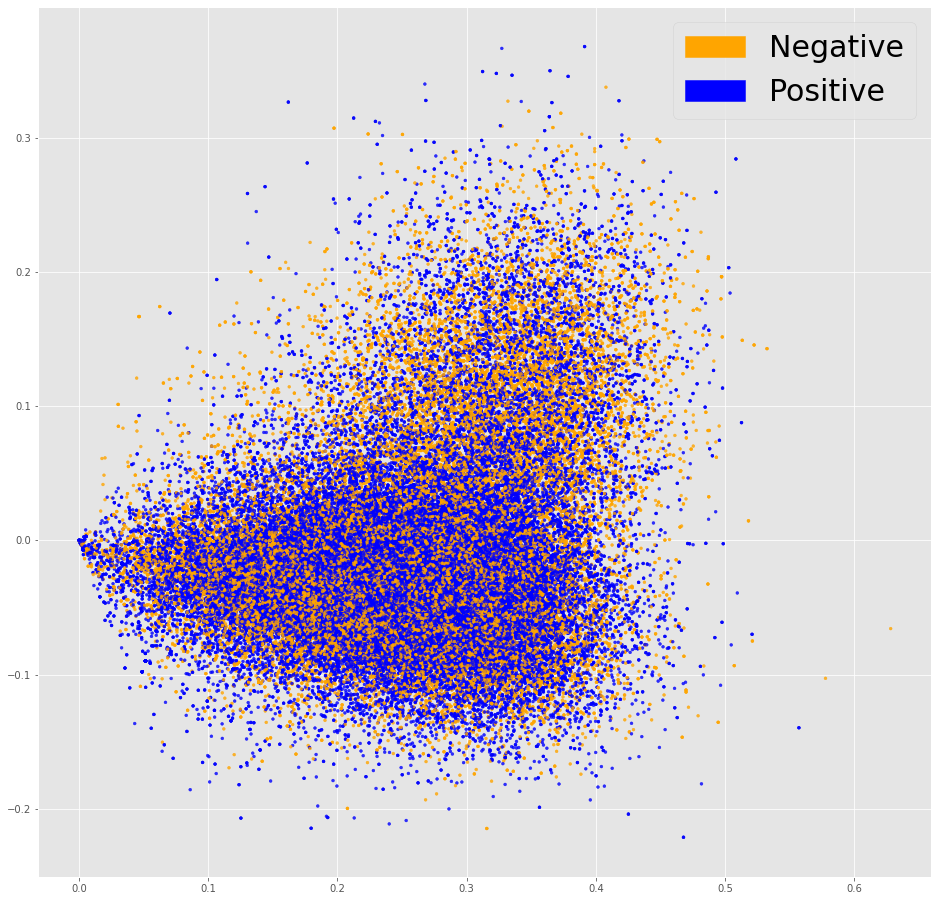

In [0]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

In [0]:
def create_corpus_new(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet)]
        corpus.append(words)
    return corpus   

In [0]:
import nltk
nltk.download('punkt')

corpus=create_corpus_new(df)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


100%|██████████| 114906/114906 [00:45<00:00, 2505.53it/s]


In [0]:
embedding_dict = np.load('/content/drive/My Drive/WSU/Semester 2/IE 7860/Final Project/glove.840B.300d.pkl', allow_pickle=True)

In [0]:
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [0]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 61971


In [0]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,300))

for word,i in tqdm(word_index.items()):
    if i < num_words:
        emb_vec=embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i]=emb_vec     

100%|██████████| 61971/61971 [00:00<00:00, 489074.90it/s]


In [0]:
tweet_pad[0][0:]


array([  643,    27,    13,   801,    44,     4,   101,    19,  2242,
         379,  2073,   275, 25091,   329,   469,   697, 13565,   661,
          27,  2073,    58,   481,    16,    49,   163,   470, 25092,
         786,   140,   469,   697, 13565,    42,    41,   272,     4,
         119,    61,    18,   191,  2831,     3,  1211, 13566,  2073,
          18,    21,    24,   215,    34], dtype=int32)

In [0]:
model=Sequential()

embedding=Embedding(num_words,300,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=3e-4)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 300)           18591600  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 18,752,101
Trainable params: 160,501
Non-trainable params: 18,591,600
_________________________________________________________________


In [0]:
train=tweet_pad[:tweet.shape[0]]
test=tweet_pad[tweet.shape[0]:]

In [0]:
X_train,X_test,y_train,y_test=train_test_split(train,tweet['target'].values,test_size=0.2)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (68841, 50)
Shape of Validation  (17211, 50)


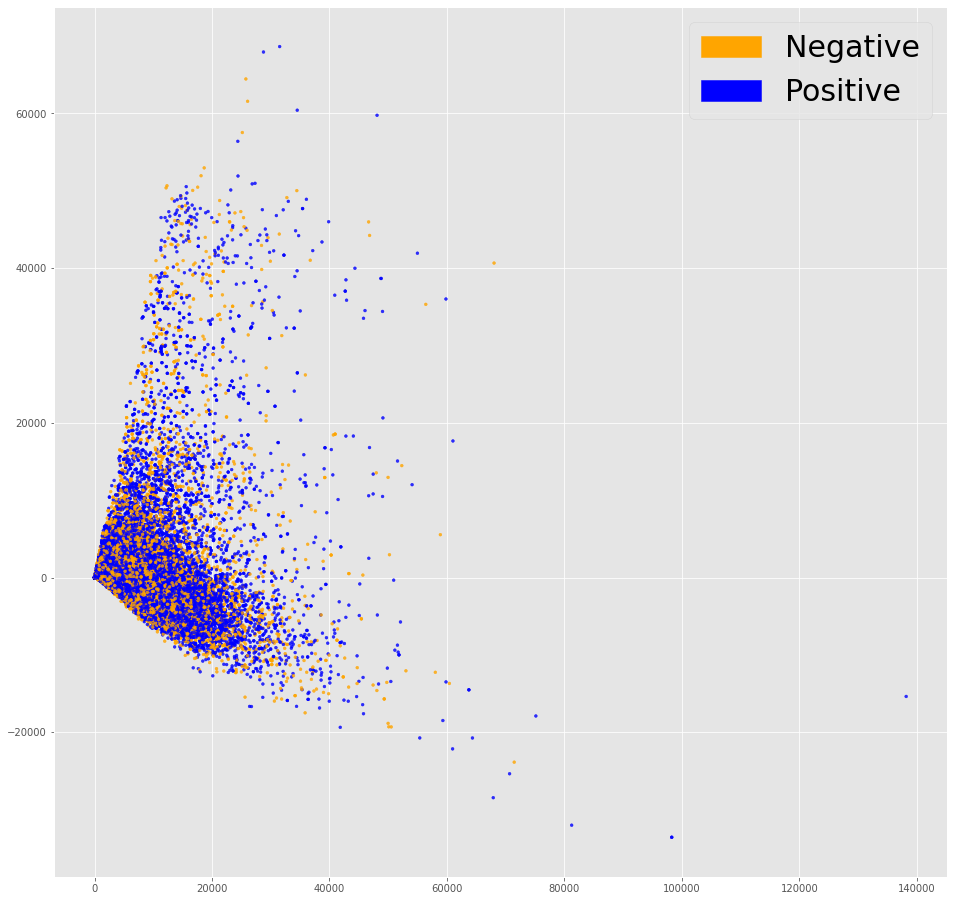

In [0]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(train,tweet['target'])
plt.show()